In [13]:
using CSV
using DataFrames
using Turing
using StatisticalRethinking
using StatsBase
using StatsPlots

default(label=false)

# 5.1 Spurious association

Code 5.1

In [4]:
d = DataFrame(CSV.File("data/WaffleDivorce.csv"))
d[!,:D] = standardize(ZScoreTransform, d.Divorce)
d[!,:M] = standardize(ZScoreTransform, d.Marriage)
d[!,:A] = standardize(ZScoreTransform, d.MedianAgeMarriage);

Code 5.2

In [6]:
std(d.MedianAgeMarriage)

1.2436303013880823

Code 5.3

In [15]:
Random.seed!(100)

@model function model_m5_1(age, divorce)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    μ = a .+ bA .* age
    divorce ~ MvNormal(μ, σ)
end

m5_1 = sample(model_m5_1(d.A, d.D), NUTS(), 1000)
m5_1_df = DataFrame(m5_1)
prior = sample(model_m5_1([0], [0]), Prior(), 1000)
prior_df = DataFrame(prior);

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/shmuma/.julia/packages/Turing/gwWVN/src/inference/hmc.jl:188


Code 5.4

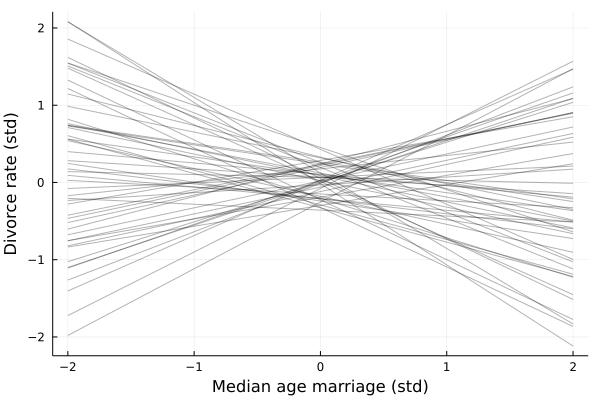

In [14]:
# calculate μ for every prior sample on age=-2 and age=2
bounds = [-2, 2]
μ = StatisticalRethinking.link(prior_df, [:a, :bA], bounds)
μ = hcat(μ...);

p = plot(xlab="Median age marriage (std)", ylab="Divorce rate (std)")
for μₚ ∈ first(eachrow(μ), 50)
    plot!(bounds, μₚ; c=:black, alpha=0.3)
end
display(p)

Code 5.5

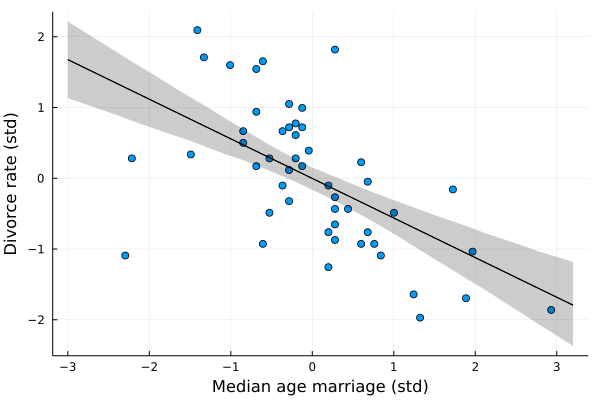

In [16]:
A_seq = range(-3, 3.2; length=30)

μ = StatisticalRethinking.link(m5_1_df, [:a, :bA], A_seq)
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = percentile.(eachcol(μ), ([5.5, 94.5],))
μ_PI = vcat(μ_PI'...)

@df d scatter(:A, :D; xlab="Median age marriage (std)", ylab="Divorce rate (std)")
plot!(A_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.2)

Code 5.6

In [17]:
Random.seed!(100)

m5_2 = sample(model_m5_1(d.M, d.D), NUTS(), 1000)
m5_2_df = DataFrame(m5_2);

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/shmuma/.julia/packages/Turing/gwWVN/src/inference/hmc.jl:188


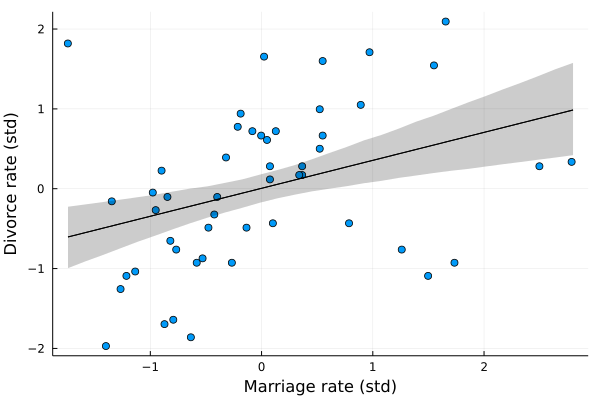

In [19]:
M_seq = range(-1.74, 2.8; length=30)

μ = StatisticalRethinking.link(m5_2_df, [:a, :bA], M_seq)
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = percentile.(eachcol(μ), ([5.5, 94.5],))
μ_PI = vcat(μ_PI'...)

@df d scatter(:M, :D; xlab="Marriage rate (std)", ylab="Divorce rate (std)")
plot!(M_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.2)